# Задание
1. Обучить на ваших данных полносвязную (неглубокую) нейронную сеть
2. Попробуйте 1-2 скрытых слоя. 
3. Постройте графики зависимости ошибки на обучающей выборке и тестовой выборках от параметра alpha и от количества нейронов. 
4. Наблюдается ли переобучение/недообучение?

In [1]:
import numpy as np          
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd       
import seaborn as sns       
import sklearn   
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка и чтение данных

In [2]:
url = "https://raw.githubusercontent.com/ParanichevaAlyona/machine_learning/main/datasets/Car_Insurance_Claim.csv"
data_raw = pd.read_csv(url)
data_raw.shape

(10000, 19)

Таблица содержит личную информацию о 10000 клиентах, разделенную на 19 категорий

### Заменим тип Object категориальных признаков на специальный тип, который предназначен для хранения как раз таких категориальных значений:

In [3]:
# сделаем копию данных, для случая, если нам понадобится исходник
data = data_raw.copy()
# теперь творим все наши изменения
data_raw['AGE'] = data_raw['AGE'].astype('category')
data_raw['GENDER'] = data_raw['GENDER'].astype('category')
data_raw['RACE'] = data_raw['RACE'].astype('category')
data_raw['DRIVING_EXPERIENCE'] = data_raw['DRIVING_EXPERIENCE'].astype('category')
data_raw['EDUCATION'] = data_raw['EDUCATION'].astype('category')
data_raw['INCOME'] = data_raw['INCOME'].astype('category')
data_raw['VEHICLE_YEAR'] = data_raw['VEHICLE_YEAR'].astype('category')
data_raw['VEHICLE_TYPE'] = data_raw['VEHICLE_TYPE'].astype('category')

### Обработаем пустоты

In [4]:
data_raw.fillna(data_raw.median(axis = 0), axis=0 , inplace=True)

### Проведем нормализацию категориальных и числовых признаков
Бинаризация категориальных признаков

In [5]:
data_raw['GENDER'] = pd.factorize(data_raw['GENDER'])[0]
data_raw['RACE'] = pd.factorize(data_raw['RACE'])[0]
data_raw['VEHICLE_YEAR'] = pd.factorize(data_raw['VEHICLE_YEAR'])[0]
data_raw['VEHICLE_TYPE'] = pd.factorize(data_raw['VEHICLE_TYPE'])[0]

In [6]:
data_raw = pd.get_dummies(data_raw)
print(data_raw.shape)

(10000, 30)


Теперь нормализуем количественные признаки, приведя значения к отрезку [0,1]

In [7]:
data_normal = (data_raw - data_raw.min(axis=0)) / (data_raw.max(axis=0) - data_raw.min(axis=0))

In [8]:
data_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10000 non-null  float64
 1   GENDER                     10000 non-null  float64
 2   RACE                       10000 non-null  float64
 3   CREDIT_SCORE               10000 non-null  float64
 4   VEHICLE_OWNERSHIP          10000 non-null  float64
 5   VEHICLE_YEAR               10000 non-null  float64
 6   MARRIED                    10000 non-null  float64
 7   CHILDREN                   10000 non-null  float64
 8   POSTAL_CODE                10000 non-null  float64
 9   ANNUAL_MILEAGE             10000 non-null  float64
 10  VEHICLE_TYPE               10000 non-null  float64
 11  SPEEDING_VIOLATIONS        10000 non-null  float64
 12  DUIS                       10000 non-null  float64
 13  PAST_ACCIDENTS             10000 non-null  floa

In [9]:
data_normal.head()

,ID,GENDER,RACE,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,...,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_high school,EDUCATION_none,EDUCATION_university,INCOME_middle class,INCOME_poverty,INCOME_upper class,INCOME_working class
0,0.569490,0.0,0.0,0.634374,1.0,0.0,0.0,1.0,0.000000,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.750358,1.0,0.0,0.335441,0.0,1.0,0.0,0.0,0.000000,0.70,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.199825,0.0,0.0,0.484636,1.0,1.0,0.0,0.0,0.000000,0.45,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.478825,1.0,0.0,0.168222,1.0,1.0,0.0,1.0,0.275179,0.45,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.731654,1.0,0.0,0.369171,1.0,1.0,0.0,0.0,0.275179,0.50,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Выбор обучающей и тестовой выборки

In [10]:
X = data_normal.drop (['ID', 'OUTCOME'], axis=1) 
y = data_raw['OUTCOME']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(7500, 2500)

In [12]:
mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

X_train = (X_train - mean) / std
X_test =  (X_test  - mean) / std

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Подбор гиперпараметров
## Подбор числа нейронов в однослойном классификаторе
В качестве алгоритма оптимизации выберем алгоритм Adam, в качестве функции активации выберем Relu, в качетве метрики оценки классификатора возьмем accuracy_score.

In [13]:
n_array = np.linspace(1, 50, 50)
n_array = n_array.astype(int)
test_err = []
train_err = []
test_acc = []
train_acc = []

for n in n_array:
    mlp_model = MLPClassifier(hidden_layer_sizes = (n,),
                          solver = 'adam', 
                          max_iter=10000,
                          activation = 'relu',
                          random_state = 42)
    mlp_model.fit(X_train, y_train)
    y_train_pred = mlp_model.predict(X_train) 
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

In [14]:
print("Минимальное значение ошибки на обучающей выборке достигнуто при количестве нейронов: " + str(n_array[np.argmin(train_err)]))
print(np.min(train_err))

print("Минимальное значение ошибки на тестовой выборке достигнуто при количестве нейронов: " + str(n_array[np.argmin(test_err)]))
print(np.min(test_err))

Минимальное значение ошибки на обучающей выборке достигнуто при количестве нейронов: 50
0.09506666666666666
Минимальное значение ошибки на тестовой выборке достигнуто при количестве нейронов: 4
0.1556


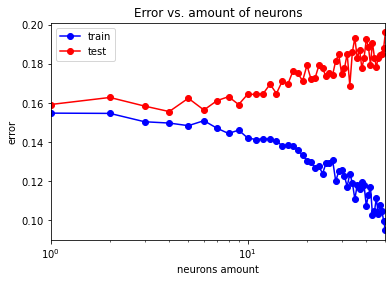

In [15]:
plt.semilogx(n_array, train_err, 'b-o', label = 'train')
plt.semilogx(n_array, test_err, 'r-o', label = 'test')
plt.xlim([np.min(n_array), np.max(n_array)])
plt.title('Error vs. amount of neurons')
plt.xlabel('neurons amount')
plt.ylabel('error')
plt.legend()

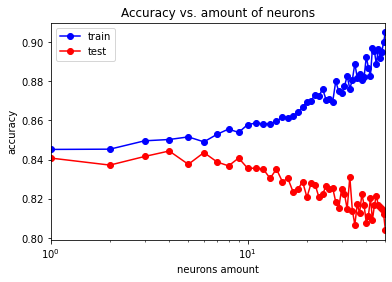

In [16]:
plt.semilogx(n_array, train_acc, 'b-o', label = 'train')
plt.semilogx(n_array, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(n_array), np.max(n_array)])
plt.title('Accuracy vs. amount of neurons')
plt.xlabel('neurons amount')
plt.ylabel('accuracy')
plt.legend()

### Подбор параметра регуляризации alpha

In [17]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
test_acc = []
train_acc = []

for alpha in alpha_arr :
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (5,), 
                              solver = 'adam', activation = 'relu', max_iter=100000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print("Минимальное значение ошибки на обучающей и тестовой выборках:")
print(min_train_err, min_test_err)
    
alpha_opt = alpha_arr[test_err == min_test_err]
print("Оптимальное значение параметра:" + str(alpha_opt[0]))

Минимальное значение ошибки на обучающей и тестовой выборках:
0.1472 0.1532
Оптимальное значение параметра:3.1622776601683795


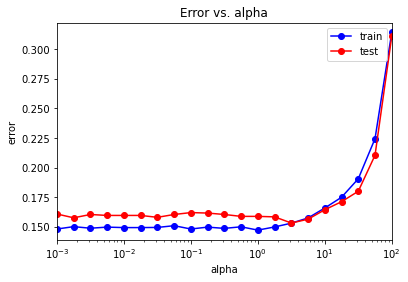

In [18]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

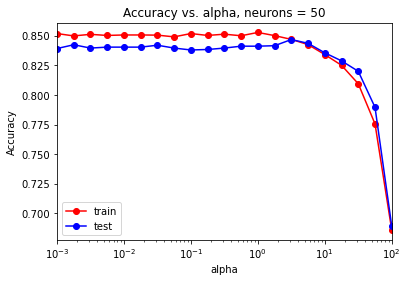

In [19]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha, neurons = ' + str(n))
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

### Обучение при оптимальном значении alpha

In [20]:
alpha_optimal = alpha_opt[0]
mlp_model = MLPClassifier(alpha = alpha_optimal, hidden_layer_sizes = (5,),
                          solver = 'adam', activation = 'relu', max_iter=100000, random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print("Ошибка на обучающей выборке: " + str(np.mean(y_train != y_train_pred)))
print("Ошибка на тестовой выборке: " + str(np.mean(y_test != y_test_pred)))

Ошибка на обучающей выборке: 0.15306666666666666
Ошибка на тестовой выборке: 0.1532


In [24]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[1559  219]
 [ 164  558]]


# Выводы
### Подбор числа нейронов в однослойном классификаторе
1. Лучший результат вышел при количестве нейронов равном 4
2. Показатели ошибок всё ещё достаточно большие (что связано со сложностью исследуемой модели), но при найденных оптимальных значениях параметров они лучше (accuracy 85%), чем показатели ошибок в методе ближайших соседей (accuracy 81%).
3. Нет недообучения и переобучения

### Подбор параметра регуляризации
C ростом коэффициента регуляризации растет ошибка и падает accuracy, что говорит о том, что после обучения у модели не возникает больших значений весовых коэффициентов, а значит нет переобучения у модели.